In [5]:
import mlrun
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name="ny-taxi-pip-demo", user_project=True, context="./"
)

> 2022-11-17 11:39:25,135 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 11:39:25,136 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 11:39:25,168 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 11:39:40,530 [info] loaded project ny-taxi-pip-demo from None or context and saved in MLRun DB


In [6]:
project.set_function('src/data_prep.py', 'data-prep', image='mlrun/ml-models',
                     handler='data_preparation', kind="job")
project.set_function('src/trainer.py', 'trainer', image='mlrun/ml-models',
                     handler='train', kind="job")
project.set_function("hub://auto_trainer", 'evaluate', image='mlrun/ml-models',
                     handler='evaluate', kind="job")
project.set_function("src/serving.py", name='serving', image='mlrun/ml-models',
                     kind="serving")
project.save()

In [7]:
# Register the workflow file:
workflow_name = "lgbm_ny_taxi_pipeline"
project.set_workflow(workflow_name, "src/workflow.py")

# Save the project:
project.save()

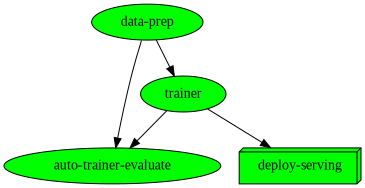

> 2022-11-17 11:54:42,011 [warning] No slack webhook is set, skipping notification
[info] Workflow 87b18ba5-3ad4-49e5-8cad-c85afadd8c14 finished, state=Succeeded
status     name                   uid       results
---------  ---------------------  --------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
completed  auto-trainer-evaluate  ..623528  evaluation_mean_absolute_error=1.7564292851316972,evaluation_r2_score=0.7929773832118485,evaluation_root_mean_squared_error=4.51690312168384,evaluation_mean_squared_error=20.402413810677217
completed  trainer                ..16edda  best_iteration=10,mean_absolute_error=1.7227900405194607,r2_score=0.849940843097176,root_mean_squared_error=3.847131317630638,mean_squared_error=14.800419375094448
completed  data-prep              ..c710ca  label_column=fare_amount


uid,start,state,name,parameters,results
...22623528,Nov 17 11:50:41,completed,auto-trainer-evaluate,model=store://artifacts/ny-taxi-pip-demo-davesh/lgbm_ny_taxi:87b18ba5-3ad4-49e5-8cad-c85afadd8c14label_columns=fare_amount,evaluation_mean_absolute_error=1.7564292851316972evaluation_r2_score=0.7929773832118485evaluation_root_mean_squared_error=4.51690312168384evaluation_mean_squared_error=20.402413810677217
...1916edda,Nov 17 11:40:06,completed,trainer,,best_iteration=10mean_absolute_error=1.7227900405194607r2_score=0.849940843097176root_mean_squared_error=3.847131317630638mean_squared_error=14.800419375094448
...e2c710ca,Nov 17 11:39:50,completed,data-prep,,label_column=fare_amount


In [8]:
workflow_run = project.run(
    name=workflow_name,
    arguments={
        "dataset": "https://s3.us-east-1.wasabisys.com/iguazio/data/nyc-taxi/train.csv",
    },
    watch=True,
)

In [9]:
serving_function = project.get_function("serving")

In [10]:
response = serving_function.invoke(path='/predict', body= {'pickup_longitude':-1.291193, 'pickup_latitude':0.711038, 'dropoff_longitude':-1.291353, 'dropoff_latitude': 0.710814, 
                                               'passenger_count':1, 'jfk_dist':40.446493, 'ewr_dist':32.342093, 'lga_dist':21.273835, 'sol_dist':14.063759, 'nyc_dist':5.607925, 
                                               'timestamp': '2013-01-01T12'})
print(response)

> 2022-11-17 11:55:21,170 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-pip-demo-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 7.095398324203971'
